## Incremental GSE

### Project defence. Kubentayeva Meruza

Bernstein A., Kuleshov A. P. Manifold Learning: Generalization Ability and Tangent Proximity // International Journal of Software and Informatics. 2013. No. 7(3). P. 359-390.

In [1]:
import networkx as nx

In [2]:
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from sets import Set

/home/meruza/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: the sets module is deprecated


### Dataset and parameters for Incremental GSE

## Attention!
Parameters epsilon_1, ..., epsilon_2 should be properly chosen. These parameters very depends on the scale of the data!!!

In [3]:
import pandas as pd 

digits_data = pd.read_csv('train.csv')

In [4]:
train_data = digits_data.sample(frac = 0.025, random_state = 2000191)
data = np.asarray(train_data.drop('label', 1))
color = train_data[['label']]
n_points = data.shape[0]
data.shape

(1050, 784)

In [5]:
#n_points = 2000
#data, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
#data, color = datasets.make_swiss_roll(n_points)
epsilon_1 = 1e5 #for Euclidean epsilon-ball
epsilon_2 = 1e-9 #Euclidean kernel parameter
epsilon_3 = 0.9 #Gaussian kernel parameter (for Binet-Cauchy metric) < 1.0
intrisic_dimension = 25
k_neighbors = 50
#swiss roll good embedding parametres:
#epsilon_1 = 2.3, epsilon_2 = 0.1, epsilon_3 = 0.5, n_points = 2000

In [ ]:
for index in range(data.shape[0]):
    temp = euclidean_distances(data, np.asmatrix(data[index]))
    res = (temp[np.where(temp < 2650.0)])
    if len(res) <= 15:
        print('Damn it: ' + str(index))
    #print((temp[np.where(temp < 2300.0)] ))
print('OK')

In [6]:
temp = pairwise_distances(data, np.asmatrix(data[100]), metric = 'l1')
a = temp[np.where(temp != 0.0)]
min(a)

17312.0

In [26]:
a = set(list(range(10)))
a.update([1, 11])
a

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11}

## HERE STARTS CODE. DO NOT CHANGE. JUST RUN ALL BELOW. 

In [6]:
def GetKNearestAndEpsBallIndices(samples, center, k_neighs = 20, eps_1 = 1e-2, metric = 'l1'):
    distances_from_center = pairwise_distances(samples, np.asmatrix(center), metric = 'l1')
    indices_in_ball = np.argwhere(distances_from_center.flatten() < eps_1)
    indices = set(indices_in_ball.flatten())
    nbrs = NearestNeighbors(n_neighbors = k_neighs)
    nbrs.fit(samples)
    dists, neighs_indices = nbrs.kneighbors(np.asmatrix(center))
    indices.update(neighs_indices.flatten())
    return indices

def ComputeManhattanKernel(points, center, eps_2 = 1e-3):
    distances = pairwise_distances(points, np.asmatrix(center), metric = 'l1')
    center_kernels = np.exp(- eps_2 * np.power(distances.flatten(), 2))
    return center_kernels

def GetKNearestNeighbors(samples, center, k_neighs = 20):
    nbrs = NearestNeighbors(n_neighbors= k_neighs)
    nbrs.fit(samples)
    dists, neighs_indices = nbrs.kneighbors(np.asmatrix(center))
    return neighs_indices.flatten()

def GetSampleIndicesInEpsBall(samples, ball_center, eps_1 = 1e-2):
    distances_from_center = euclidean_distances(samples, np.asmatrix(ball_center))
    indices_in_ball = np.argwhere(distances_from_center.flatten() < eps_1)
    return indices_in_ball.flatten()

def ComputeEuclideanKernel(points, center, eps_2 = 1e-3):
    squared_distances = euclidean_distances(points, np.asmatrix(center), squared = True)
    center_kernels = np.exp(- eps_2 * squared_distances.flatten())
    return center_kernels

def ComputeWheightedPCA(weights, points, intrisic_dim_):
    average = np.sum((weights * points.T).T, axis = 0)
    centered_points = points - average
    scaled_centered_points = (np.sqrt(weights) * centered_points.T).T
    v = np.linalg.svd(scaled_centered_points)[2]
    Q_pca = v[:intrisic_dim_, :].transpose()
    assert (scaled_centered_points.shape[0] == points.shape[0]), "Shapes not similar"
    
    return Q_pca

In [7]:
def AddNodesToManifoldGraph(graph, data, points_list, every_point_neighbors, every_point_euclid_kernels):
    for point_index in points_list:
        euclid_neighbors_indices = list(GetKNearestAndEpsBallIndices(data, data[point_index], k_neighbors, epsilon_1, 'l1'))
        #euclid_neighbors_indices = GetKNearestNeighbors(data, data[point_index], k_neighbors)
        #euclid_neighbors_indices = GetSampleIndicesInEpsBall(data, data[point_index], epsilon_1)
        every_point_neighbors[point_index] = euclid_neighbors_indices

        euclid_neighbors = data[euclid_neighbors_indices]

        euclid_kernels = ComputeManhattanKernel(euclid_neighbors, data[point_index], epsilon_2)
        #euclid_kernels = ComputeEuclideanKernel(euclid_neighbors, data[point_index], epsilon_2)
        every_point_euclid_kernels[point_index] = euclid_kernels.tolist()

        #compute weights for every point
        kernels_sum = euclid_kernels.sum()
        point_weights = euclid_kernels / kernels_sum

        Q_pca = ComputeWheightedPCA(point_weights, euclid_neighbors, intrisic_dimension)

        graph.add_node(point_index, Q_PCA = Q_pca)

        print('computed for ' + str(point_index))

In [8]:
def ComputeBinetCauchyKernel(Q_first, Q_second):
    S_first_second = np.dot(Q_first.transpose(), Q_second)
    assert(S_first_second.shape == (intrisic_dimension, intrisic_dimension))
    S_determinant = np.linalg.det(S_first_second)
    bc_kernel = S_determinant**2
    return bc_kernel, S_first_second

def DeleteFromListComputedNeighbor(point_index_, neighbor_index_,
                                   every_point_neighbors, every_point_euclid_kernels):
    if (neighbor_index_ in every_point_neighbors[point_index_]):
        index = every_point_neighbors[point_index_].index(neighbor_index_)
        del every_point_neighbors[point_index_][index]
        del every_point_euclid_kernels[point_index_][index]

def AddEdgesToManifoldGraph(graph, points_list, data, every_point_neighbors, every_point_euclid_kernels):
    for point_index in points_list:
        while(every_point_neighbors[point_index]):
            neighbor_index = every_point_neighbors[point_index].pop()
            euclid_kernel = every_point_euclid_kernels[point_index].pop()
            bc_kernel, S_point_neighbor = ComputeBinetCauchyKernel(graph.node[point_index]['Q_PCA'], 
                                                                   graph.node[neighbor_index]['Q_PCA'])
                
            aggregate_kernel = euclid_kernel * float(1.0 - bc_kernel < epsilon_3) * bc_kernel
            
            if (aggregate_kernel > 0):
                length = np.linalg.norm(data[point_index] - data[neighbor_index]) / aggregate_kernel
                graph.add_edge(point_index, neighbor_index, weight = length, S_first_second = S_point_neighbor,
                                        kernel = aggregate_kernel)
                graph.add_edge(neighbor_index, point_index, weight = length, S_first_second = S_point_neighbor.T,
                                        kernel = aggregate_kernel)
            #delete from list computed points
            DeleteFromListComputedNeighbor(neighbor_index, point_index,
                                           every_point_neighbors, every_point_euclid_kernels)

In [31]:
# for experiments

In [9]:
# Create graph
manifold_graph = nx.DiGraph()
points_list = range(n_points)
#============================================
every_point_neighbors = {}
every_point_kernels = {} 
#======================================
#Compute for every node Q_pca
AddNodesToManifoldGraph(manifold_graph, data, points_list, every_point_neighbors, every_point_kernels)
print('Nodes are added and its attributes are calculated')

computed for 0
computed for 1
computed for 2
computed for 3
computed for 4
computed for 5
computed for 6
computed for 7
computed for 8
computed for 9
computed for 10
computed for 11
computed for 12
computed for 13
computed for 14
computed for 15
computed for 16
computed for 17
computed for 18
computed for 19
computed for 20
computed for 21
computed for 22
computed for 23
computed for 24
computed for 25
computed for 26
computed for 27
computed for 28
computed for 29
computed for 30
computed for 31
computed for 32
computed for 33
computed for 34
computed for 35
computed for 36
computed for 37
computed for 38
computed for 39
computed for 40
computed for 41
computed for 42
computed for 43
computed for 44
computed for 45
computed for 46
computed for 47
computed for 48
computed for 49
computed for 50
computed for 51
computed for 52
computed for 53
computed for 54
computed for 55
computed for 56
computed for 57
computed for 58
computed for 59
computed for 60
computed for 61
computed for 62
co

In [10]:
## NO NEED TO LAUNCH IT
import copy
every_point_neighbors_copy = copy.deepcopy(every_point_neighbors)
every_point_kernels_copy = copy.deepcopy(every_point_kernels)

In [45]:
every_point_neighbors = copy.deepcopy(every_point_neighbors_copy)
every_point_kernels = copy.deepcopy(every_point_kernels_copy)

In [11]:
#compute Aggregate kernel for every neighbor of every point
#construct manifold_graph
AddEdgesToManifoldGraph(manifold_graph, points_list, data, every_point_neighbors, every_point_kernels)
print('Edges are added and its attributes are calculated')
print('Criteria on graph conectivity: ' + str(nx.is_strongly_connected(manifold_graph)))

Edges are added and its attributes are calculated
Criteria on graph conectivity: True


If we got NOT CONNECTED graph, it means that we chose WRONG PARAMETERS

In [12]:
def GetNodesOrder(length_dict):
    order_list = []
    position_list = np.empty(len(length_dict))
    num = 0
    for key, value in sorted(length_dict.iteritems(), key=lambda (k,v): (v,k)):
        order_list.append(key)
        position_list[key] = num
        num += 1
    return order_list, position_list

In [13]:
#Compute min eccentricity node and order
all_pairs_shortest_paths = nx.shortest_path_length(manifold_graph, weight = 'weight')
eccentricities = nx.eccentricity(manifold_graph, sp = all_pairs_shortest_paths)
first_node = min(eccentricities, key = eccentricities.get)
#first_node = 1
nodes_order, position_arr = GetNodesOrder(all_pairs_shortest_paths[first_node])

In [14]:
#Compute Manifold Embedding
#Initialization
v_first_node = np.eye(intrisic_dimension)
h_first_node = np.zeros(intrisic_dimension)
manifold_graph.node[nodes_order[0]]['v_matrix'] = v_first_node
manifold_graph.node[nodes_order[0]]['h_embedding'] = h_first_node

for node in nodes_order[1:]:
    kernel_sum = 0.0
    matrix_sum = np.zeros((intrisic_dimension, intrisic_dimension))
    h_sum = np.zeros(intrisic_dimension)
    x_sum = np.zeros(data.shape[1])
    for neighbor, neigh_dict in manifold_graph[node].iteritems():
        if (position_arr[neighbor] < position_arr[node]):
            kernel = neigh_dict['kernel'] 
            matrix_sum += kernel * neigh_dict['S_first_second'].dot(manifold_graph.node[neighbor]['v_matrix'])
            h_sum += kernel * manifold_graph.node[neighbor]['h_embedding']
            x_sum += kernel * data[neighbor]
            kernel_sum += kernel

    v_final = matrix_sum / kernel_sum
    h_final = h_sum / kernel_sum + np.linalg.inv(v_final).dot(manifold_graph.node[node]['Q_PCA'].T).dot(data[node] - 
              x_sum / kernel_sum)
    manifold_graph.node[node]['v_matrix'] = v_final
    manifold_graph.node[node]['h_embedding'] = h_final

In [15]:
data_embedding = [manifold_graph.node[node]['h_embedding'] for node in range(n_points)]
data_embedding = np.array(data_embedding)

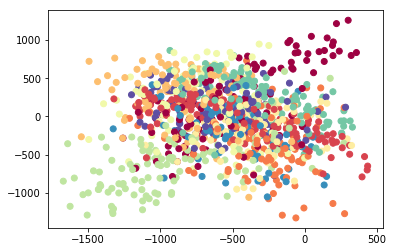

In [31]:
plt.scatter(data_embedding[:, 5], data_embedding[:, 3], c=color, cmap=plt.cm.Spectral)
plt.show()

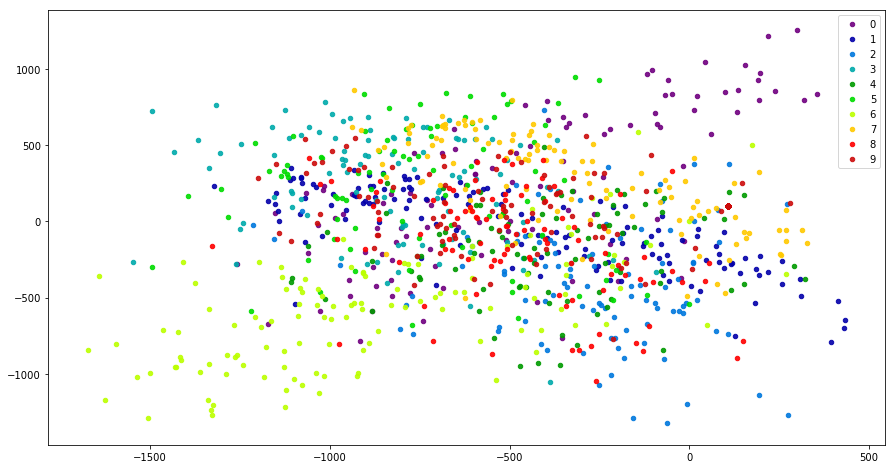

In [33]:
plt.figure(figsize=(15,8))
for i in range(10):
    ind = np.argwhere(np.array(color) == i)
    plt.scatter(data_embedding[ind,5], data_embedding[ind, 3], 
                c=plt.cm.spectral(0.1 * (i + 0.5)), s = 20, label=i, alpha = 0.9)
plt.legend()
plt.show()

In [31]:
temp = euclidean_distances(data_embedding, np.asmatrix(data_embedding[104]))
a = temp[np.where(temp != 0.0)]
np.median(a)

2835.5584465499492

## Manifold Reconstruction

In [58]:
k_neigh_emb = 8
eps_emb = 1e3

In [37]:
def ComputeBinetCauchyGaussKernel(Q_first, Q_second, eps_3 = 1e1):
    S_first_second = np.dot(Q_first.transpose(), Q_second)
    assert(S_first_second.shape == (intrisic_dimension, intrisic_dimension))
    S_determinant = np.linalg.det(S_first_second)
    bc_kernel = float(1.0 - S_determinant**2 < eps_3) * S_determinant**2
    return bc_kernel, S_first_second

def ReconstructManifold(data_for_reconstruct, data_embedding):
    #Compute for every node y Projector_pca*
    every_point_neigh_indices = {}
    dict_Q_rec_point = {}
    dict_Q_rec_neigh = {}
    #========================================
    unique_neighs_indices = set()

    for point_index in range(data_for_reconstruct.shape[0]):
        neighbors_indices = GetKNearestAndEpsBallIndices(data_embedding, 
                                                         data_for_reconstruct[point_index], 
                                                         k_neigh_emb, eps_emb, 'l2')
        #rec_neighbors_indices = GetKNearestNeighbors(data_embedding, data_embedding[rec_point_index], k_neighs = 20)
        #rec_neighbors_indices = GetSampleIndicesInEpsBall(data_embedding, data_embedding[rec_point_index], epsilon_1 * 0.05)
        every_point_neigh_indices[point_index] = list(neighbors_indices)
        unique_neighs_indices.update(list(neighbors_indices))

        Q_rec = ComputeWheightedPCA(np.ones(len(neighbors_indices)), 
                                    data[list(neighbors_indices)], intrisic_dimension)
        assert(Q_rec.shape[1] == intrisic_dimension), "Q_rec shape error"

        #manifold_graph.node[rec_point_index]['projector'] = Q_rec.dot(Q_rec.transpose())  !!!!! p x p 
        #TODO: change in first implementation
        dict_Q_rec_point[point_index] = Q_rec
        print('neighbors computed for ' + str(point_index))

    #Added function. Compute Q_rec for neighs of points_for_reconstruct
    for neigh_index in unique_neighs_indices:
        neighbors_indices = GetKNearestAndEpsBallIndices(data_embedding, data_embedding[neigh_index],
                                                         k_neigh_emb, eps_emb, 'l2')
        #rec_neighbors_indices = GetKNearestNeighbors(data_embedding, data_embedding[neigh_index], k_neighs = 20)

        Q_rec = ComputeWheightedPCA(np.ones(len(neighbors_indices)),
                                    data[list(neighbors_indices)], intrisic_dimension)
        dict_Q_rec_neigh[neigh_index] = Q_rec
        
    #==================================================================================================================
    #==================================================================================================================
    
    #Compute reconstruction function for each point y in Y_n
    reconstructed_data = []

    ####!!!!! n_points -> points_for_reconstruct
    for point_index in range(data_for_reconstruct.shape[0]):
        kernel_sum = 0.0
        G_matrix_sum = np.zeros((data.shape[1], intrisic_dimension))
        X_sum = np.zeros(data.shape[1])
        y_residuals_sum = np.zeros(intrisic_dimension)

        Q_rec_point = dict_Q_rec_point[point_index]

        neigh_indices = every_point_neigh_indices[point_index]
        print('neighbors computed for ' + str(point_index))
        for neigh_index in neigh_indices:
            neigh_dict = manifold_graph.node[neigh_index]
            Q_rec_neigh = dict_Q_rec_neigh[neigh_index]
            kernel, smthing = ComputeBinetCauchyGaussKernel(Q_rec_point, Q_rec_neigh, 2)
            kernel_sum += kernel
            G_matrix_sum += kernel * neigh_dict['Q_PCA'].dot(neigh_dict['v_matrix'])
            #TODO!!!
            X_sum += kernel * data[neigh_index]
            y_residuals_sum += kernel * (data_for_reconstruct[point_index]
                                         - data_embedding[neigh_index])

            
        rec_point_projector = Q_rec_point.dot(Q_rec_point.transpose())
        G_matrix_sum = rec_point_projector.dot(G_matrix_sum) / kernel_sum
        #G_matrix_sum = rec_point_dict['projector'].dot(G_matrix_sum) / rec_kernel_sum
        g_reconstruction = (X_sum - G_matrix_sum.dot(y_residuals_sum)) / kernel_sum
        reconstructed_data.append(g_reconstruction)

    reconstructed_data = np.asarray(reconstructed_data)
    return reconstructed_data

In [39]:
def make_image_plot(point_array, plt):
    image = np.zeros((28, 28))

    for x in range(0, np.size(point_array)):
        row = np.floor_divide(x, 28)
        column = np.remainder(x, 28)
        image[row, column] = point_array[x]
        
    plt.imshow(image, cmap = 'gray')

## Test points

In [41]:
digits_data_test = pd.read_csv('test.csv')

In [42]:
digits_data_test.shape

(28000, 784)

In [51]:
test_data = np.asarray(digits_data_test[30 : 50])
test_data.shape

(20, 784)

### For One Test Point

In [45]:
def ComputeEmbeddingForNewNode(graph, train_data, test_point):
    neighbors_indices = list(GetKNearestAndEpsBallIndices(train_data, test_point, k_neighbors, epsilon_1, 'l1'))
     
    kernels = list(ComputeManhattanKernel(train_data[neighbors_indices], test_point, epsilon_2))

    #compute weights for every point
    kernels_sum = sum(kernels)
    point_weights = np.asarray(kernels) / kernels_sum

    Q_pca_test_point = ComputeWheightedPCA(point_weights, train_data[neighbors_indices], intrisic_dimension)
    #====================================================================
    dictionary_of_neighs = {}
    
    while(neighbors_indices):
        neigh_index = neighbors_indices.pop()
        euclid_kernel = kernels.pop()
        bc_kernel, S_point_neighbor = ComputeBinetCauchyGaussKernel(Q_pca_test_point , 
                                                               graph.node[neigh_index]['Q_PCA'], 
                                                                epsilon_3)
        aggregate_kernel = euclid_kernel * bc_kernel
        if (aggregate_kernel > 0):
            neigh_dict = {'kernel' : aggregate_kernel, 'S_first_second' : S_point_neighbor}
            dictionary_of_neighs[neigh_index] = neigh_dict
            #graph.add_edge(point_index, neighbor_index, weight = length, 
            #S_first_second = S_point_neighbor, kernel = bc_kernel) TODO!!!!: bc_kernel???????
    
    
    #====================================================================
    kernel_sum = 0.0
    matrix_sum = np.zeros((intrisic_dimension, intrisic_dimension))
    h_sum = np.zeros(intrisic_dimension)
    x_sum = np.zeros(data.shape[1])
    for neigh_index, neigh_dict in dictionary_of_neighs.iteritems():
        kernel = neigh_dict['kernel'] 
        matrix_sum += kernel * neigh_dict['S_first_second'].dot(graph.node[neigh_index]['v_matrix'])
        h_sum += kernel * graph.node[neigh_index]['h_embedding']
        x_sum += kernel * train_data[neigh_index]
        kernel_sum += kernel

    v_final = matrix_sum / kernel_sum
    h_final = h_sum / kernel_sum + np.linalg.inv(v_final).dot(
                      Q_pca_test_point.T).dot(test_point - x_sum / kernel_sum)
    return np.asarray([h_final])

In [ ]:
fig2 = plt.figure(figsize = (10, 60))
for index in range(20):
    test_point = test_data[index]
#======================================
    h_embedding_test = ComputeEmbeddingForNewNode(manifold_graph, data, test_point)
    reconstructed_data = ReconstructManifold(h_embedding_test, data_embedding)
    plt.subplot(20, 2, 1 + 2 * index )
    make_image_plot(reconstructed_data[0], plt)
    plt.subplot(20, 2, 2 + 2 * index)
    make_image_plot(test_point, plt)
    print(np.linalg.norm(reconstructed_data[0] - test_point, ord = 1))

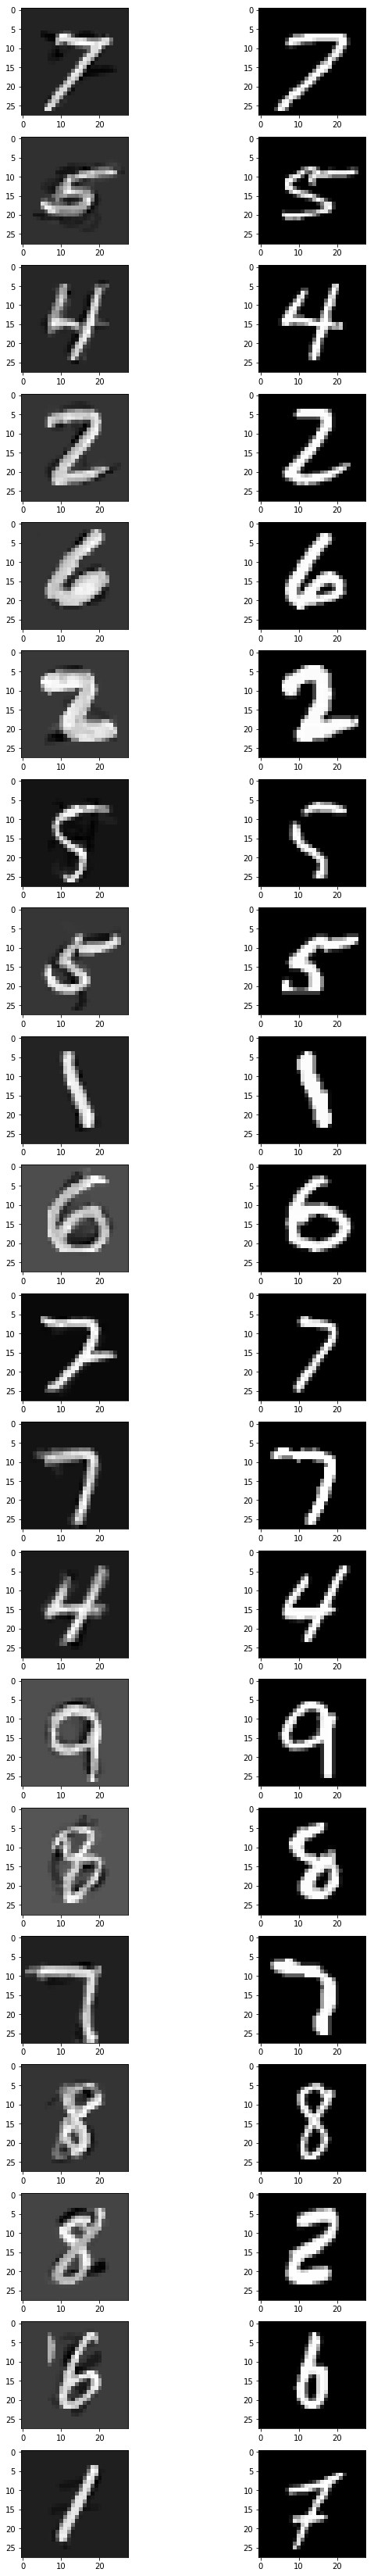

In [60]:
plt.show()